In [14]:
import pandas as pd
import torch
import re
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from datasets import load_dataset
import numpy as np
from gensim.models import KeyedVectors

#veriseti
print("Veriseti yükleniyor...")
dataset = load_dataset("Overfit-GM/turkish-toxic-language", split="train")
df = pd.DataFrame(dataset)

#metin temizleme
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"[^\w\sçğıöşüÇĞİÖŞÜ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['clean_text'] = df['text'].apply(clean_text)
df['tokens'] = df['clean_text'].apply(lambda x: x.split())

#vocab oluşturma
all_tokens = [token for tokens in df['tokens'] for token in tokens]
vocab_counter = Counter(all_tokens)
vocab = {'<PAD>': 0, '<UNK>': 1}
for idx, (word, _) in enumerate(vocab_counter.most_common(30000), start=2):
    vocab[word] = idx

#encode + pad
MAX_LEN = 75
def encode_tokens(tokens, vocab, max_len=MAX_LEN):
    ids = [vocab.get(token, vocab['<UNK>']) for token in tokens]
    return ids[:max_len] + [vocab['<PAD>']] * max(0, max_len - len(ids))

df['input_ids'] = df['tokens'].apply(lambda x: encode_tokens(x, vocab))

#etiketler
label2id = {'INSULT': 0, 'PROFANITY': 1, 'OTHER': 2, 'RACIST': 3, 'SEXIST': 4}
id2label = {v: k for k, v in label2id.items()}
df['label'] = df['target'].map(label2id)

#veri bölme train-val-test
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

def df_to_lists(df):
    return df['input_ids'].tolist(), df['label'].tolist()

train_texts, train_labels = df_to_lists(train_df)
val_texts, val_labels = df_to_lists(val_df)
test_texts, test_labels = df_to_lists(test_df)

#dataset ve dataloader
class ToxicDataset(Dataset):
    def __init__(self, input_ids, labels):
        self.input_ids = input_ids
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_loader = DataLoader(ToxicDataset(train_texts, train_labels), batch_size=32, shuffle=True)
val_loader = DataLoader(ToxicDataset(val_texts, val_labels), batch_size=32)
test_loader = DataLoader(ToxicDataset(test_texts, test_labels), batch_size=32)

# fasttext yükleme ve embedding matrisini oluşturma
embedding_dim = 300
ft_model = KeyedVectors.load_word2vec_format("/home/fef/!nlp/fef_toxic/cc.tr.300.vec", binary=False)

embedding_matrix = np.random.uniform(-0.05, 0.05, (len(vocab), embedding_dim)).astype(np.float32)
embedding_matrix[vocab['<PAD>']] = np.zeros(embedding_dim)

found = 0
for word, idx in vocab.items():
    if word in ft_model:
        embedding_matrix[idx] = ft_model[word]
        found += 1

print(f"Vocab: {len(vocab)} kelime")
print(f"Eğitim: {len(train_texts)} örnek")
print(f"Doğrulama: {len(val_texts)} örnek")
print(f"Test: {len(test_texts)} örnek")
print(f"fastText karşılanan kelime: {found} / {len(vocab)} ({(found / len(vocab)) * 100:.2f}%)")


Veriseti yükleniyor...
Vocab: 30002 kelime
Eğitim: 62240 örnek
Doğrulama: 7780 örnek
Test: 7780 örnek
fastText karşılanan kelime: 28794 / 30002 (95.97%)


In [2]:
import pickle
with open("vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)


In [3]:
import numpy as np
np.save("embedding_matrix.npy", embedding_matrix)


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from tqdm import tqdm
from collections import Counter

#focal loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, weight=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weight = weight

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

#model
class ToxicClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_classes):
        super(ToxicClassifier, self).__init__()
        vocab_size, embed_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix), freeze=False, padding_idx=0)
        self.bilstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)

        self.conv3 = nn.Conv1d(hidden_dim * 2, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(hidden_dim * 2, 128, kernel_size=4, padding=2)
        self.conv5 = nn.Conv1d(hidden_dim * 2, 128, kernel_size=5, padding=2)

        self.attn = nn.Linear(128 * 3, 1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128 * 3, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.bilstm(x)
        conv_input = lstm_out.permute(0, 2, 1)

        c3 = F.relu(self.conv3(conv_input))
        c4 = F.relu(self.conv4(conv_input))
        c5 = F.relu(self.conv5(conv_input))

        pooled = torch.cat([
            F.adaptive_max_pool1d(c3, 1).squeeze(2),
            F.adaptive_max_pool1d(c4, 1).squeeze(2),
            F.adaptive_max_pool1d(c5, 1).squeeze(2)
        ], dim=1)

        attn_weights = torch.sigmoid(self.attn(pooled))
        x = pooled * attn_weights
        x = self.dropout(x)
        return self.fc(x)

#eğitim fonk
def train_model(train_loader, val_loader, embedding_matrix, num_classes, label_counts,
                epochs=20, hidden_dim=256, lr=1e-3, patience=4, save_path="fef_toxic.pt"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ToxicClassifier(embedding_matrix, hidden_dim, num_classes).to(device)

    total = sum(label_counts.values())
    weights = []
    for i in range(num_classes):
        count = label_counts.get(i, 1) 
        weights.append(1.0 / (count / total))
    class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

    criterion = FocalLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=2, T_mult=2)

    best_val_acc = 0
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step(epoch + batch['input_ids'].shape[0] / len(train_loader))

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        print(f"\nEpoch {epoch+1} - Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f}")

        #validation
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['label'].to(device)
                outputs = model(input_ids)
                preds = outputs.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        print(f"Validation Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
            print(f"💾 En iyi model kaydedildi → {save_path}")
        else:
            patience_counter += 1
            print(f"⚠️ Gelişme yok. Beklenen epoch: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("🛑 Early stopping!")
                break

#eğitim başlat
label_counts = Counter([label for _, label in train_loader.dataset])
train_model(
    train_loader=train_loader,
    val_loader=val_loader,
    embedding_matrix=embedding_matrix,
    num_classes=5,
    label_counts=label_counts
)


Epoch 1/20: 100%|██████████| 1945/1945 [00:57<00:00, 33.79it/s] 



Epoch 1 - Loss: 59206070.2104 | Train Acc: 0.8343
Validation Acc: 0.8675
💾 En iyi model kaydedildi → fef_toxic.pt


Epoch 2/20: 100%|██████████| 1945/1945 [00:55<00:00, 34.92it/s] 



Epoch 2 - Loss: 27249824.6534 | Train Acc: 0.9274
Validation Acc: 0.8787
💾 En iyi model kaydedildi → fef_toxic.pt


Epoch 3/20: 100%|██████████| 1945/1945 [00:55<00:00, 35.26it/s] 



Epoch 3 - Loss: 22714199.4358 | Train Acc: 0.9404
Validation Acc: 0.8645
⚠️ Gelişme yok. Beklenen epoch: 1/4


Epoch 4/20: 100%|██████████| 1945/1945 [00:55<00:00, 35.04it/s] 



Epoch 4 - Loss: 15039334.3002 | Train Acc: 0.9648
Validation Acc: 0.8662
⚠️ Gelişme yok. Beklenen epoch: 2/4


Epoch 5/20: 100%|██████████| 1945/1945 [00:54<00:00, 35.61it/s] 



Epoch 5 - Loss: 12290847.2122 | Train Acc: 0.9824
Validation Acc: 0.8585
⚠️ Gelişme yok. Beklenen epoch: 3/4


Epoch 6/20: 100%|██████████| 1945/1945 [00:55<00:00, 34.99it/s] 



Epoch 6 - Loss: 7110912.9577 | Train Acc: 0.9912
Validation Acc: 0.8578
⚠️ Gelişme yok. Beklenen epoch: 4/4
🛑 Early stopping!



Classification Report:

              precision    recall  f1-score   support

      INSULT       0.77      0.69      0.73      1078
   PROFANITY       0.87      0.92      0.89      1825
       OTHER       0.92      0.95      0.93      3766
      RACIST       0.87      0.77      0.82      1017
      SEXIST       0.63      0.48      0.55        94

    accuracy                           0.88      7780
   macro avg       0.81      0.76      0.78      7780
weighted avg       0.88      0.88      0.88      7780



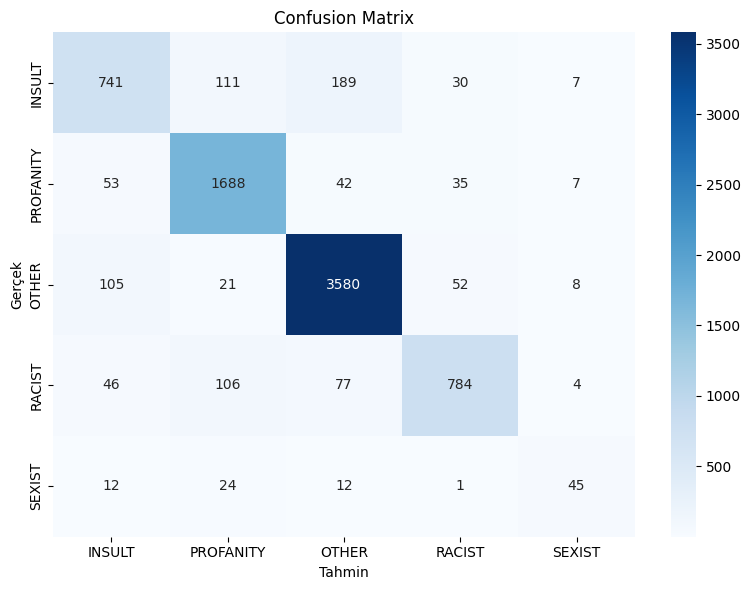

In [16]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# modeli yükle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ToxicClassifier(embedding_matrix, hidden_dim=256, num_classes=5).to(device)
model.load_state_dict(torch.load("/home/fef/!nlp/fef_toxic/fef_toxic.pt", map_location=device))
model.eval()

#tüm test verisinde tahmin yap
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#classification report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=list(label2id.keys()), digits=2))

#confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=list(label2id.keys()),
            yticklabels=list(label2id.keys()),
            cmap="Blues")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
import gradio as gr
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import time
import re
import pickle
import numpy as np
from datetime import datetime

# dosya yerleri
VOCAB_PATH = "/home/fef/!nlp/fef_toxic/vocab.pkl"
EMBED_PATH = "/home/fef/!nlp/fef_toxic/embedding_matrix.npy"
MODEL_PATH = "/home/fef/!nlp/fef_toxic/fef_toxic.pt"

# temizleme encode
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"[^\w\sçğıöşüÇĞİÖŞÜ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

MAX_LEN = 75
def encode_tokens(tokens, vocab, max_len=MAX_LEN):
    ids = [vocab.get(token, vocab['<UNK>']) for token in tokens]
    return ids[:max_len] + [vocab['<PAD>']] * max(0, max_len - len(ids))

# etiketler
label2id = {'INSULT': 0, 'PROFANITY': 1, 'OTHER': 2, 'RACIST': 3, 'SEXIST': 4}
id2label = {v: k for k, v in label2id.items()}

# model
class ToxicClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_classes):
        super(ToxicClassifier, self).__init__()
        vocab_size, embed_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix), freeze=False, padding_idx=0)
        self.bilstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.conv3 = nn.Conv1d(hidden_dim * 2, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(hidden_dim * 2, 128, kernel_size=4, padding=2)
        self.conv5 = nn.Conv1d(hidden_dim * 2, 128, kernel_size=5, padding=2)
        self.attn = nn.Linear(128 * 3, 1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128 * 3, 5)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.bilstm(x)
        conv_input = lstm_out.permute(0, 2, 1)
        c3 = F.relu(self.conv3(conv_input))
        c4 = F.relu(self.conv4(conv_input))
        c5 = F.relu(self.conv5(conv_input))
        pooled = torch.cat([
            F.adaptive_max_pool1d(c3, 1).squeeze(2),
            F.adaptive_max_pool1d(c4, 1).squeeze(2),
            F.adaptive_max_pool1d(c5, 1).squeeze(2)
        ], dim=1)
        attn_weights = torch.sigmoid(self.attn(pooled))
        x = pooled * attn_weights
        x = self.dropout(x)
        return self.fc(x)

# dosyalar
with open(VOCAB_PATH, "rb") as f:
    vocab = pickle.load(f)

embedding_matrix = np.load(EMBED_PATH)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ToxicClassifier(embedding_matrix, hidden_dim=256, num_classes=5).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# tahmin fonk
def get_prediction(text):
    tokens = clean_text(text).split()
    input_ids = encode_tokens(tokens, vocab)
    input_tensor = torch.tensor([input_ids], dtype=torch.long).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        pred_id = probs.argmax(dim=1).item()
        confidence = probs[0][pred_id].item()
    return pred_id, confidence

# değişkenler
latest_text = ""
latest_pred_label = ""
latest_conf = 0.0

# tahmin arayüzü
def predict_and_show(text):
    global latest_text, latest_pred_label, latest_conf
    pred_id, conf = get_prediction(text)
    label = id2label[pred_id]
    explanation = {
        "INSULT": "🔴 Hakaret",
        "PROFANITY": "🔴 Küfür",
        "RACIST": "🔴 Irkçılık",
        "SEXIST": "🔴 Cinsiyetçilik",
        "OTHER": "🟢 Toksik Değil"
    }[label]

    latest_text = text
    latest_pred_label = label
    latest_conf = conf
    return f"{explanation}\nTahmin: {label}\nGüven: %{conf*100:.2f}", gr.update(visible=True)

def submit_feedback(feedback, correct_label):
    global latest_text, latest_pred_label, latest_conf
    is_correct = feedback == "Doğru"
    correct = latest_pred_label if is_correct else correct_label
    df = pd.DataFrame([{
        "text": latest_text,
        "model_prediction": latest_pred_label,
        "confidence": f"{latest_conf:.4f}",
        "is_correct": is_correct,
        "correct_label": correct,
        "timestamp": datetime.now().isoformat()
    }])
    df.to_csv("feedback_log.csv", mode="a", index=False, header=not pd.io.common.file_exists("feedback_log.csv"))

    submit_btn_text = gr.update(value="✅ Geri bildiriminiz kaydedildi.", visible=True)
    time.sleep(1)
    return gr.update(value="Gönder", visible=True), submit_btn_text

# gradio arayüzü
with gr.Blocks() as demo:
    gr.Markdown("# Türkçe Toksisite Sınıflandırma Projesi")

    with gr.Row():
        input_text = gr.Textbox(label="Bir cümle girin", lines=2)
        output_text = gr.Textbox(label="Model Tahmini")
    predict_btn = gr.Button("Tahmin Et")

    feedback_section = gr.Column(visible=False)
    with feedback_section:
        feedback_choice = gr.Radio(["Doğru", "Yanlış"], label="Bu tahmin doğru mu?", value="Doğru")
        correct_label_dropdown = gr.Dropdown(choices=list(id2label.values()), label="Doğru etiketi seçin", visible=False)
        submit_btn = gr.Button("Gönder")
        feedback_output = gr.Textbox(visible=False)

    def toggle_dropdown(choice):
        return gr.update(visible=(choice == "Yanlış"))

    predict_btn.click(fn=predict_and_show, inputs=input_text, outputs=[output_text, feedback_section])
    feedback_choice.change(fn=toggle_dropdown, inputs=feedback_choice, outputs=correct_label_dropdown)
    submit_btn.click(fn=submit_feedback, inputs=[feedback_choice, correct_label_dropdown], outputs=[submit_btn, feedback_output])

demo.launch()


/home/fef/env_gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
